In [1]:
import pandas as pd
import fastai.transforms as transforms
import fastai.torch_imports as torch_imports
import fastai.conv_learner as conv_learner
import fastai.dataset as dataset
import PIL as PIL
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import FileLink

ModuleNotFoundError: No module named 'fastai.transforms'

In [2]:
PATH = './data/breeds/'
labels = pd.read_csv(f'{PATH}labels.csv')
print(labels.shape[0])
labels.head()

10222


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [37]:
torch_imports.cuda.set_device(0)

In [4]:
arch = conv_learner.resnext101_64
val_idxs = dataset.get_cv_idxs(labels.shape[0])
# magic numbers
sz = 224
bs = 58

# EDA

In [5]:
df = labels.groupby('breed').agg(len).sort_values('id', ascending=False)
print(df.head())
print(df.tail())

                       id
breed                    
scottish_deerhound    126
maltese_dog           117
afghan_hound          116
entlebucher           115
bernese_mountain_dog  114
                   id
breed                
golden_retriever   67
brabancon_griffon  67
komondor           67
briard             66
eskimo_dog         66


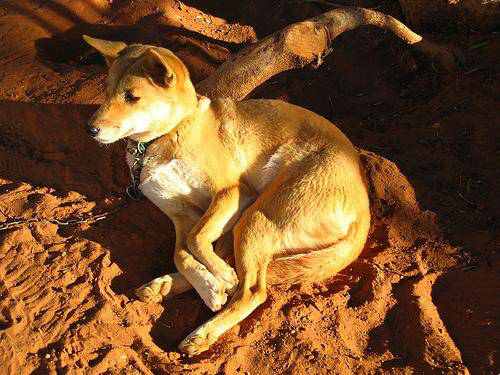

In [6]:
tfms = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)
data = dataset.ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', tfms=tfms,
                                            val_idxs=val_idxs, suffix='.jpg', bs=bs)
fn = PATH + data.trn_ds.fnames[0]
img = PIL.Image.open(fn)
img

In [7]:
img.size

(500, 375)

In [8]:
szs = [PIL.Image.open(PATH + fn).size for fn in data.trn_ds.fnames]
xs = np.array([v[0] for v in szs])
ys = np.array([v[1] for v in szs])

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


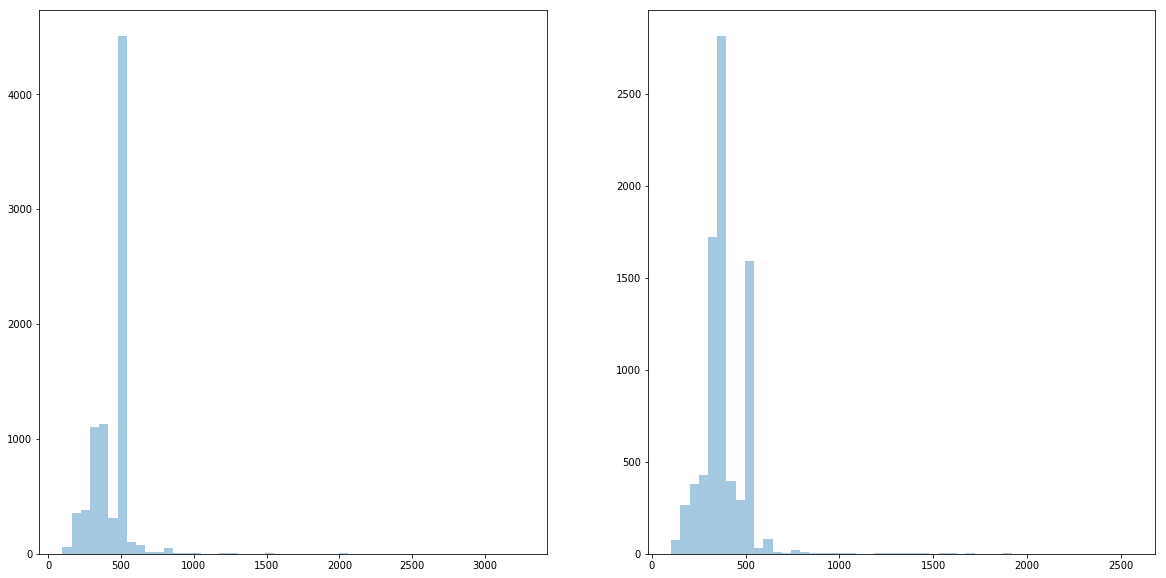

In [9]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.distplot(xs, ax=ax1, kde=False)
sns.distplot(ys, ax=ax2, kde=False)

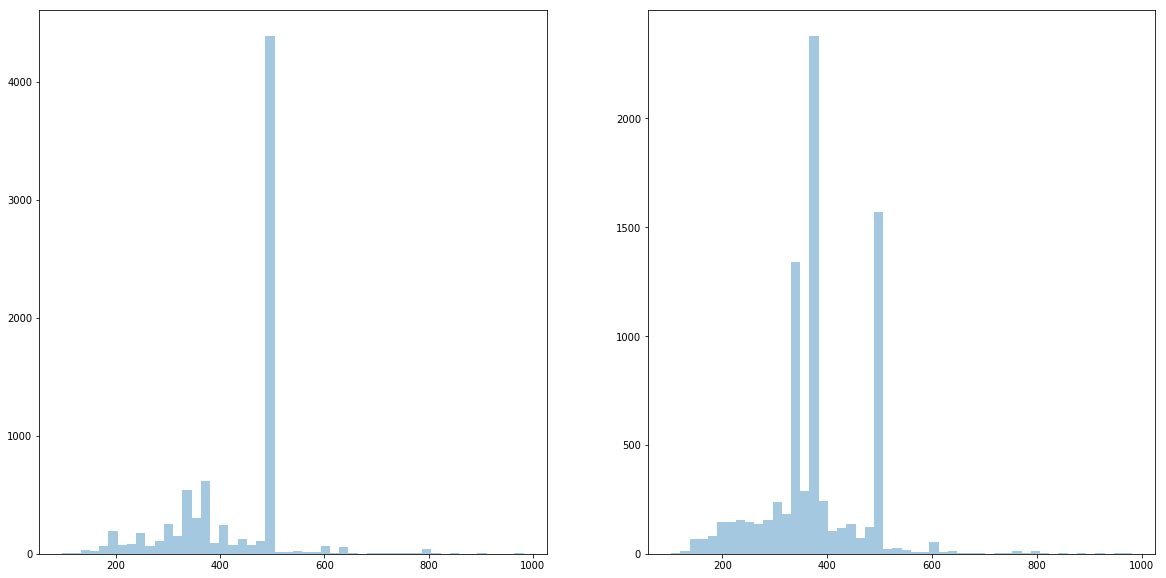

In [10]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
sns.distplot(xs[xs < 1000], ax=ax1, kde=False)
sns.distplot(ys[ys < 1000], ax=ax2, kde=False)

In [14]:
data.classes[:5], len(data.classes)

(['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'],
 120)

# Model

In [19]:
def get_data(sz,bs):
    tfms = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)
    data = dataset.ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', tfms=tfms,
                                            val_idxs=val_idxs, suffix='.jpg', bs=bs)
    # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time
    return data if sz > 300 else data.resize(340, 'tmp') 

## Precompute

In [21]:
data = get_data(sz,bs)
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.929644   0.388873   0.906556  
    1      0.419166   0.311215   0.905577                    



[array([0.31122]), 0.9055773020373865]

## Augment

In [22]:
data = get_data(sz, bs)
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(1e-2, 2, cycle_len=1)
learn.precompute = False
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.52346    0.797857   0.865949  
    1      0.750423   0.435525   0.898239                    



epoch      trn_loss   val_loss   accuracy                    
    0      0.605771   0.348145   0.909002  
    1      0.514767   0.306413   0.913405                    
    2      0.460515   0.286021   0.913405                    
    3      0.408345   0.26818    0.918297                    
    4      0.363823   0.25807    0.919765                    



[array([0.25807]), 0.919765167273654]

In [24]:
learn.save('224_pre')
learn.load('224_pre')

## Increase Image Size

In [32]:
# Starting training on small images for a few epochs, then switching to bigger images,
# and continuing training is an amazingly effective way to avoid overfitting.

# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs))
learn.freeze()

In [33]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [34]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.360033   0.246317   0.918297  
    1      0.342804   0.237637   0.917808                    
    2      0.32722    0.233813   0.916341                    



[array([0.23381]), 0.9163405138219173]

In [36]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.296739   0.226762   0.920744  
    1      0.282751   0.227816   0.925636                    
    2      0.263714   0.221847   0.928082                    
    3      0.259967   0.231261   0.924658                    
    4      0.234758   0.220522   0.927104                    
    5      0.209446   0.216736   0.925147                    
    6      0.207703   0.21528    0.928571                    



[array([0.21528]), 0.9285714308459698]

In [49]:
log_preds, y = learn.TTA()

In [59]:
preds = np.exp(log_preds)
probs = np.mean(preds, 0)
acc = (np.argmax(probs, 1) == y).mean()
loss = metrics.log_loss(y, probs)
print(acc)
print(loss)

0.9305283757338552
0.20961045609948703


In [61]:
learn.save('299_pre')
learn.load('299_pre')

In [62]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.213109   0.222189   0.926125  
    1      0.20029    0.222349   0.927104                    



[array([0.22235]), 0.9271037171498203]

In [63]:
learn.save('299_pre')

In [64]:
log_preds, y = learn.TTA()
preds = np.exp(log_preds)
probs = np.mean(preds, 0)
acc = (np.argmax(probs, 1) == y).mean()
loss = metrics.log_loss(y, probs)
print(acc)
print(loss)

0.9315068493150684                            
0.21834934247714755


In [65]:
# If dataset was signigicantly different to image net, would consider unfreezing pretrained layers 
# and retraining them with a low learning rate here.

# Submit

In [67]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [70]:
data.test_ds.fnames

['test/fd1a7be32f10493735555e62913c0841.jpg',
 'test/5273d42f02b4715cb93845205995ef64.jpg',
 'test/442057a3142f4d75a1023db363e2fb54.jpg',
 'test/fb03302b030afd122e0f4936c158f6c1.jpg',
 'test/511ca6e3539192aa5c8747bb697e0525.jpg',
 'test/2e60533a26e589f57fff34711c5ba73c.jpg',
 'test/27e4bd954bfe78f9e01338dc5108fadd.jpg',
 'test/591566259cbc95dd43b75d77b00aa7a5.jpg',
 'test/a51c2803972dff8c7fcc17f6b7eda64d.jpg',
 'test/9ace4c5cced4fb88678a5b0a9b3f3cf1.jpg',
 'test/0a4ef19459cd2100977b052de5f46231.jpg',
 'test/d1d5b398aaee58ef3d6d7cde20cf17ac.jpg',
 'test/5f93b0c2f5941449705b44ac56555740.jpg',
 'test/a8c328b54ad54952071ca471aaaf9bf8.jpg',
 'test/7b5f0257ec767a039aaf95246561163b.jpg',
 'test/01d5ffa4de01074483149bec0f6e5a59.jpg',
 'test/e12e6997c15c233c7b92209e08ff9d14.jpg',
 'test/b79c8019e5558042de2fd1105defec28.jpg',
 'test/cca524a4ee4fbbea4a867767377f2035.jpg',
 'test/873c14fc563d7d83e6de1253ab6ab67f.jpg',
 'test/99b7f212ca1c54282f01dfb98efbaea3.jpg',
 'test/cb7c8ef5b03d79feb9cf5416836

In [72]:
log_preds, y = learn.TTA(is_test=True)

In [77]:
preds = np.exp(log_preds)
probs = np.mean(preds, 0)
probs.shape

(10357, 120)

In [91]:
ids = pd.Series([s[5:-4] for s in data.test_ds.fnames], name='id')
submit_df = pd.concat([ids, pd.DataFrame(probs, columns=data.classes)], axis=1)
submit_df.head()

id  affenpinscher  afghan_hound  \
0  fd1a7be32f10493735555e62913c0841   8.145338e-06  3.366268e-06   
1  5273d42f02b4715cb93845205995ef64   6.651793e-06  1.584450e-05   
2  442057a3142f4d75a1023db363e2fb54   1.468711e-07  1.776533e-06   
3  fb03302b030afd122e0f4936c158f6c1   2.468280e-04  3.819371e-06   
4  511ca6e3539192aa5c8747bb697e0525   1.227281e-06  1.884732e-07   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         5.015709e-08  2.766518e-07                    7.022857e-08   
1         5.790959e-05  5.926527e-05                    8.444857e-06   
2         9.662529e-08  7.826745e-07                    1.921934e-07   
3         3.336906e-07  5.684479e-08                    2.181511e-07   
4         6.765109e-07  9.507972e-09                    7.751066e-07   

    appenzeller  australian_terrier       basenji        basset  \
0  7.645340e-09        6.965848e-07  6.250029e-09  7.139893e-08   
1  1.887486e-06        2.213969e-06  8.332127e-07  8.233387e-06   
2  6.072386e-06        1.191368e-07  7.599181e-08  2.036373e-06   
3  1.785531e-07        4.472282e-07  3.761652e-07  1.956522e-07   
4  9.963014e-07        4.824364e-05  1.544252e-07  8.419393e-08   

         ...            toy_poodle   toy_terrier        vizsla  walker_hound  \
0        ...          1.259223e-05  9.376019e-08  2.032124e-07  2.154106e-08   
1        ...          1.725619e-06  9.135489e-07  4.359792e-05  1.913813e-05   
2        ...          6.553974e-08  1.262666e-06  4.551690e-07  9.395920e-05   
3        ...          1.345951e-04  3.767770e-07  8.458090e-08  6.794208e-08   
4        ...          2.730365e-04  8.004322e-07  3.604798e-07  1.650598e-08   

     weimaraner  welsh_springer_spaniel  west_highland_white_terrier  \
0  9.094249e-08            7.939584e-08                 1.142106e-08   
1  8.084571e-05            5.014666e-05                 6.323337e-06   
2  5.977668e-06            1.665184e-08                 1.898339e-07   
3  6.123122e-07            2.674680e-07                 1.478967e-06   
4  1.318876e-06            3.039660e-07                 1.086912e-04   

        whippet  wire-haired_fox_terrier  yorkshire_terrier  
0  1.068033e-07             1.271713e-06       4.092525e-07  
1  3.171563e-04             3.980865e-05       1.952457e-05  
2  1.585527e-07             1.546416e-08       6.393390e-07  
3  1.256169e-07             7.336065e-08       7.524536e-05  
4  2.454047e-07             2.414810e-06       4.606679e-05  

[5 rows x 121 columns]

In [96]:
submit_df.to_csv('./submit/submit_01.gz', compression='gzip', index=False)

In [97]:
FileLink('./submit/submit_01.gz')

/home/ubuntu/mlsabbatical/notebooks/breeds/submit/submit_01.gz